In [2]:
# -------------------------------------------------
# Task 2.2 – Cross-country comparison of HICP
# Requirements: pip install fredapi pandas matplotlib
# -------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# 1. Load FRED API key from file and create a Fred object
with open("fredapi_key.txt", "r") as f:
    fred = Fred(api_key=f.read().strip())

FileNotFoundError: [Errno 2] No such file or directory: 'fredapi_key.txt'

In [3]:
# 2. Series codes for HICP (All Items), by country/area
SERIES_CODES = {
    "Denmark": "CP0000DKM086NEST",
    "Austria": "CP0000ATM086NEST",
    "Euro Area": "CP0000EZCCM086NEST",   # Euro Area HICP (All Items)
    "United States": "CP0000USM086NEST", # Harmonized CPI for the US
}

# Helper function: download a series safely and return as pandas Series
def fetch_series(series_id: str) -> pd.Series:
    sid = series_id.strip().upper()  # remove hidden whitespace/newlines
    s = fred.get_series(sid)
    s.name = sid
    return s

# 3. Download all series into one DataFrame
data_columns = {}
for region, sid in SERIES_CODES.items():
    s = fetch_series(sid)
    s.name = region  # rename column to readable label
    data_columns[region] = s

hicp = pd.concat(data_columns.values(), axis=1)

NameError: name 'fred' is not defined

In [3]:
# Ensure datetime index
hicp.index = pd.to_datetime(hicp.index)

# Keep only observations from 2019 onward
hicp = hicp.loc[hicp.index >= "2019-01-01"]

# 4. Compute 12-month (year-over-year) inflation rates
# Formula: inflation_t = (HICP_t / HICP_{t-12} - 1) * 100
inflation_yoy = hicp.pct_change(periods=12) * 100

/var/folders/4c/1ss308gn5cjfp7yk68sdqn9m0000gn/T/ipykernel_17254/1099468422.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation_yoy = hicp.pct_change(periods=12) * 100


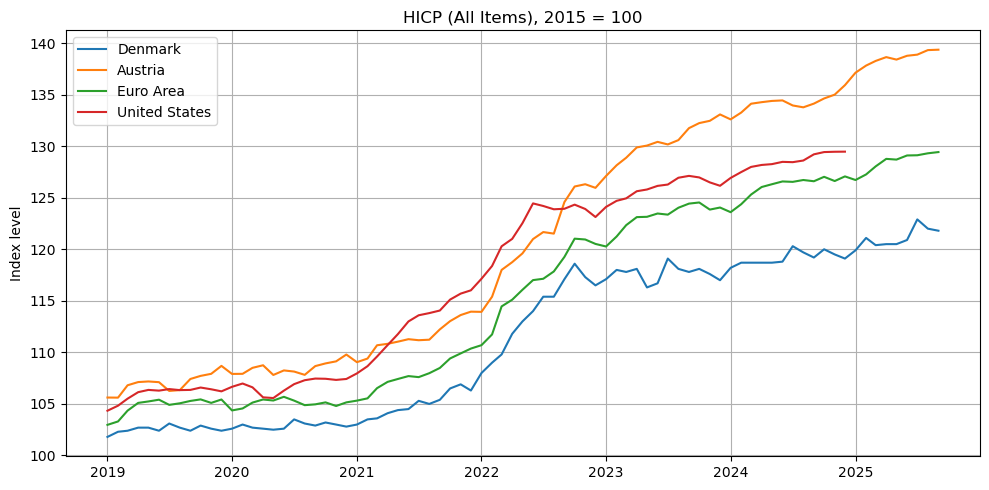

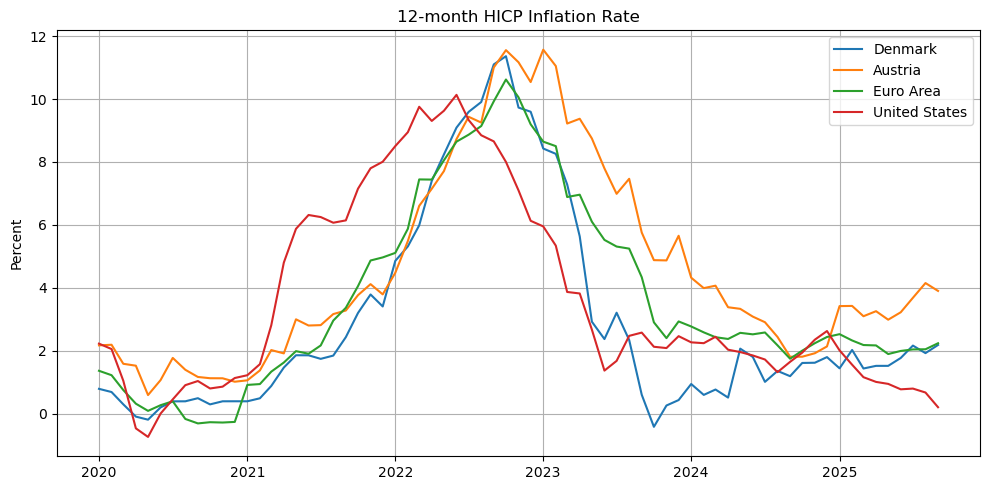

In [4]:
# 5. Plot HICP index levels
plt.figure(figsize=(10,5))
for country in hicp.columns:
    plt.plot(hicp.index, hicp[country], label=country)
plt.title("HICP (All Items), 2015 = 100")
plt.ylabel("Index level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot 12-month HICP inflation rates
plt.figure(figsize=(10,5))
for country in inflation_yoy.columns:
    plt.plot(inflation_yoy.index, inflation_yoy[country], label=country)
plt.title("12-month HICP Inflation Rate")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# 7. Yearly summary statistics:
#    For each year and each country, compute the min, max, and mean
annual_stats = (
    inflation_yoy
    .resample("Y")          # calendar year (year-end frequency)
    .agg(["min", "max", "mean"])
    .round(2)
)

print("\n=== Yearly statistics for 12-month HICP inflation (percent) ===")
print("(Rows = year, Columns = country, Sub-columns = min / max / mean)\n")
print(annual_stats)

# 8. Average inflation since 2019 by country
avg_since_2019 = inflation_yoy.mean().round(2)
print("\n=== Average 12-month HICP inflation since 2019 (percent) ===")
print(avg_since_2019)

# 9. Text summary you can use in the write-up
print("\nSummary:")
print("- All four regions experienced a clear inflation surge in 2021–2022 compared to 2019–2020.")
print("- The United States tends to peak earlier and more sharply than the Euro Area,")
print("  suggesting stronger domestic demand pressures in the U.S. early in the period.")
print("- Denmark and Austria closely track the Euro Area pattern,")
print("  with similar timing of the energy/food shock.")
print("- After the peak, inflation declines across all regions from 2023 onward,")
print("  but the speed and level differ somewhat across countries.")


/var/folders/4c/1ss308gn5cjfp7yk68sdqn9m0000gn/T/ipykernel_17254/2111721119.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")          # calendar year (year-end frequency)



=== Yearly statistics for 12-month HICP inflation (percent) ===
(Rows = year, Columns = country, Sub-columns = min / max / mean)

           Denmark              Austria              Euro Area               \
               min    max  mean     min    max  mean       min    max  mean   
2019-12-31     NaN    NaN   NaN     NaN    NaN   NaN       NaN    NaN   NaN   
2020-12-31   -0.19   0.79  0.33    0.59   2.19  1.39     -0.31   1.36  0.26   
2021-12-31    0.39   3.79  1.94    1.06   4.11  2.76      0.91   4.96  2.59   
2022-12-31    4.85  11.36  8.51    4.48  11.55  8.59      5.11  10.62  8.36   
2023-12-31   -0.42   8.43  3.44    4.87  11.57  7.78      2.40   8.64  5.48   
2024-12-31    0.51   2.06  1.27    1.81   4.32  2.93      1.74   2.77  2.37   
2025-12-31    1.43   2.18  1.77    2.98   4.15  3.46      1.89   2.52  2.15   

           United States               
                     min    max  mean  
2019-12-31           NaN    NaN   NaN  
2020-12-31         -0.74   2.22  0.77

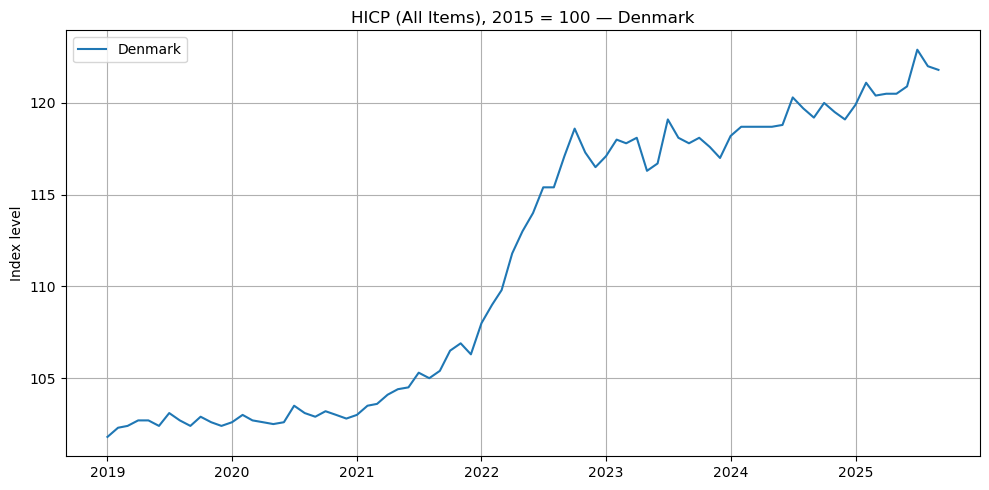

In [6]:
plt.figure(figsize=(10,5))
plt.plot(hicp.index, hicp["Denmark"], label="Denmark")
plt.title("HICP (All Items), 2015 = 100 — Denmark")
plt.ylabel("Index level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# C. Merge wages and prices at quarterly frequency (English labels)

# Rename columns to English-friendly names first
df_q = pd.concat(
    [
        dk_wage_q.rename(columns={"DK_wage_index_2015eq100": "Hourly_wage_index_2015eq100"}),
        dk_hicp_q.rename(columns={"DK_hicp_index_2015eq100": "Consumer_price_index_2015eq100"}),
    ],
    axis=1,
    join="inner"
).dropna()

# D. Real wage index

df_q["Real_wage_index_2015eq100"] = (
    df_q["Hourly_wage_index_2015eq100"] / df_q["Consumer_price_index_2015eq100"] * 100
)

# Rebase real wages so that the 2019 average = 100
base_2019 = df_q.loc[df_q.index.year == 2019, "Real_wage_index_2015eq100"].mean()
df_q["Real_wage_index_2019avg100"] = (
    df_q["Real_wage_index_2015eq100"] / base_2019 * 100
)

# E. Figure 1: Nominal wages vs consumer prices

plt.figure(figsize=(10,5))
plt.plot(
    df_q.index,
    df_q["Hourly_wage_index_2015eq100"],
    label="Hourly wage (private sector), 2015=100"
)
plt.plot(
    df_q.index,
    df_q["Consumer_price_index_2015eq100"],
    label="Consumer prices (HICP), 2015=100"
)
plt.title("Denmark: Wages vs Prices (quarterly)")
plt.ylabel("Index (2015=100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# F. Figure 2: Real wages (purchasing power)

plt.figure(figsize=(10,5))
plt.plot(
    df_q.index,
    df_q["Real_wage_index_2019avg100"],
    label="Real hourly wage (2019=100)"
)
plt.title("Denmark: Real Wages (hourly wage deflated by consumer prices)")
plt.ylabel("Index (2019=100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined